# COVID-19 County-Level Case Analysis  
**Exploratory Data Analysis Report**  
Prepared by: Navid Bahadorn  
Date: June, 2025

This report presents a preliminary analysis of COVID-19 county-level case data in the United States, including spatial and temporal trends.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from config import config

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)

### 1. Dataset Summary

We first look at the dimensions and basic statistics of the dataset.


In [2]:
data_path = config["data_path"]
df = pd.read_csv(data_path)

# Restore dates from "t"
start_date = datetime(2020, 1, 21)
df["date"] = pd.to_datetime(df["t"], unit="D", origin=start_date)

print("Loaded shape:", df.shape)
display(df.head())
print(df.info())

Loaded shape: (2409352, 5)


,lon,lat,t,u,date
0,-164.040108,64.942121,85,10.167768,2020-04-15
1,-164.040108,64.942121,86,10.167768,2020-04-16
2,-164.040108,64.942121,87,10.167768,2020-04-17
3,-164.040108,64.942121,88,10.167768,2020-04-18
4,-164.040108,64.942121,89,10.167768,2020-04-19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409352 entries, 0 to 2409351
Data columns (total 5 columns):
 #   Column  Dtype         
---  ------  -----         
 0   lon     float64       
 1   lat     float64       
 2   t       int64         
 3   u       float64       
 4   date    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 91.9 MB
None


### 2. Summary Statistics & Nulls

In [3]:
print("Summary Statistics:")
display(df.describe())

print("Null Value Check:")
print(df.isnull().sum())


Summary Statistics:


,lon,lat,t,u,date
count,2.409352e+06,2.409352e+06,2.409352e+06,2.409352e+06,2409352
mean,-9.214093e+01,3.838049e+01,4.573247e+02,1.011351e+04,2021-04-22 07:47:36.891645440
min,-1.640401e+02,1.960199e+01,0.000000e+00,1.028686e-02,2020-01-21 00:00:00
25%,-9.808979e+01,3.464985e+01,2.650000e+02,2.138229e+03,2020-10-12 00:00:00
50%,-9.024324e+01,3.832408e+01,4.580000e+02,9.257088e+03,2021-04-23 00:00:00
75%,-8.343685e+01,4.174292e+01,6.510000e+02,1.522107e+04,2021-11-02 00:00:00
max,-6.762834e+01,6.935328e+01,8.430000e+02,3.843137e+05,2022-05-13 00:00:00
std,1.261735e+01,5.230411e+00,2.235216e+02,8.760030e+03,NaN


Null Value Check:
lon     0
lat     0
t       0
u       0
date    0
dtype: int64


### 3.Unique Locations & Data Coverage

In [4]:
print(f"Unique locations (lon, lat): {df[['lon','lat']].drop_duplicates().shape[0]}")
print(f"Time Range: {df['date'].min().date()} to {df['date'].max().date()}")

Unique locations (lon, lat): 3124
Time Range: 2020-01-21 to 2022-05-13


**Observation:**  
The dataset includes infection rate per 100,000 people (`u`) over time for each U.S. county. The data ranges from Jan 2020 onwards and appears to be normalized by population.

---


### 4.Sample Time Series for a Random or Top County
We examine the infection trend over time for a sample location with the most data points.

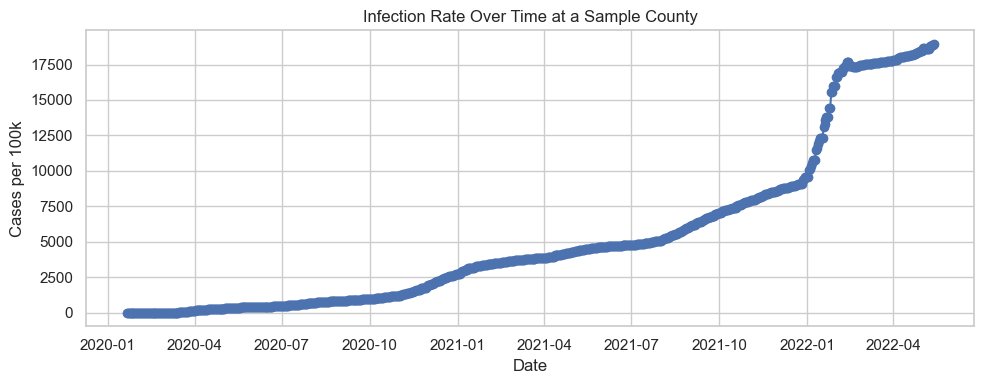

In [5]:
loc = df.groupby(["lon", "lat"]).size().sort_values(ascending=False).index[0]
df_sample = df[(df["lon"] == loc[0]) & (df["lat"] == loc[1])]

plt.figure(figsize=(10, 4))
plt.plot(df_sample["date"], df_sample["u"], marker="o")
plt.title("Infection Rate Over Time at a Sample County")
plt.xlabel("Date")
plt.ylabel("Cases per 100k")
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis:**  
This county shows distinct surges during known COVID waves (e.g., early 2021, late 2021/Omicron). The infection rate exhibits strong temporal spikes followed by rapid declines, consistent with public health intervention cycles.

---


### 5. National Average Trend
Here, we analyze the average infection rate across all counties each day.

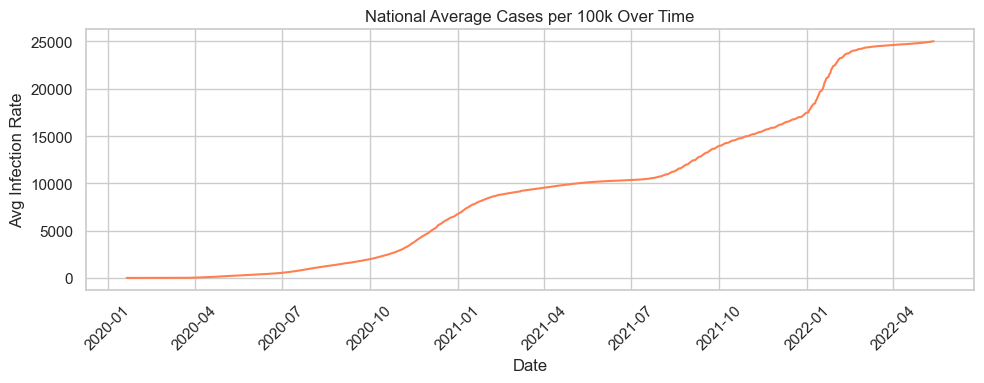

In [6]:
df_national = df.groupby("date")["u"].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_national, x="date", y="u", color="coral")
plt.title("National Average Cases per 100k Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Infection Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis:**  
National averages smooth out county-level noise and highlight broad pandemic waves. The three major surges are clearly visible, corresponding to initial outbreak, Delta, and Omicron waves.

---


### 6. Heatmap: Top Locations
We now plot trends for the top 5 counties by data density.

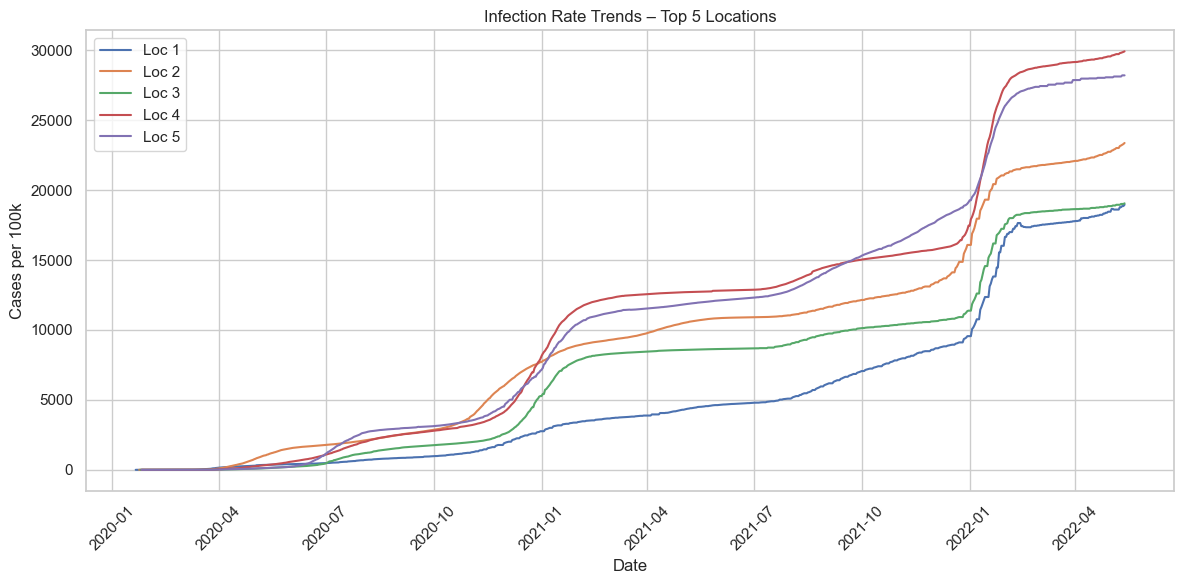

In [7]:
# Get top 5 locations with most records
top5_locs = df.groupby(["lon", "lat"]).size().sort_values(ascending=False).head(5).index

# Plot time series for each
plt.figure(figsize=(12, 6))
for i, loc in enumerate(top5_locs):
    df_sub = df[(df["lon"] == loc[0]) & (df["lat"] == loc[1])]
    plt.plot(df_sub["date"], df_sub["u"], label=f"Loc {i+1}")
plt.legend()
plt.title("Infection Rate Trends – Top 5 Locations")
plt.xlabel("Date")
plt.ylabel("Cases per 100k")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Analysis:**  
Comparing different counties reveals variations in timing and magnitude of infection waves. Some counties show delayed or prolonged peaks, possibly due to differences in population density, interventions, or mobility.

---


### Heatmap of a specific time slice

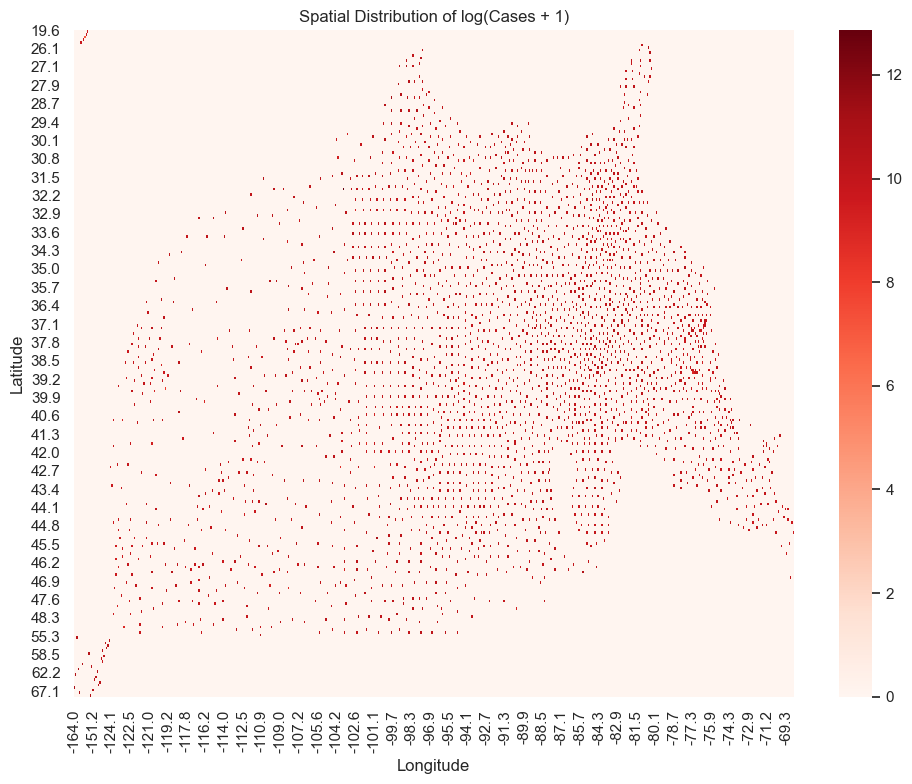

In [4]:
df_t = df[df["t"] == df["t"].max()].copy()
df_t["lat_round"] = df_t["lat"].round(1)
df_t["lon_round"] = df_t["lon"].round(1)

heatmap_data = df_t.pivot_table(index="lat_round", columns="lon_round", values="u", aggfunc="mean")
heatmap_data = heatmap_data.fillna(0)

# Optionally log-scale for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(np.log1p(heatmap_data), cmap="Reds")
plt.title("Spatial Distribution of log(Cases + 1)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### 7.Daily Histogram of Cases per 100k
Next, we examine how infection rates are distributed overall.

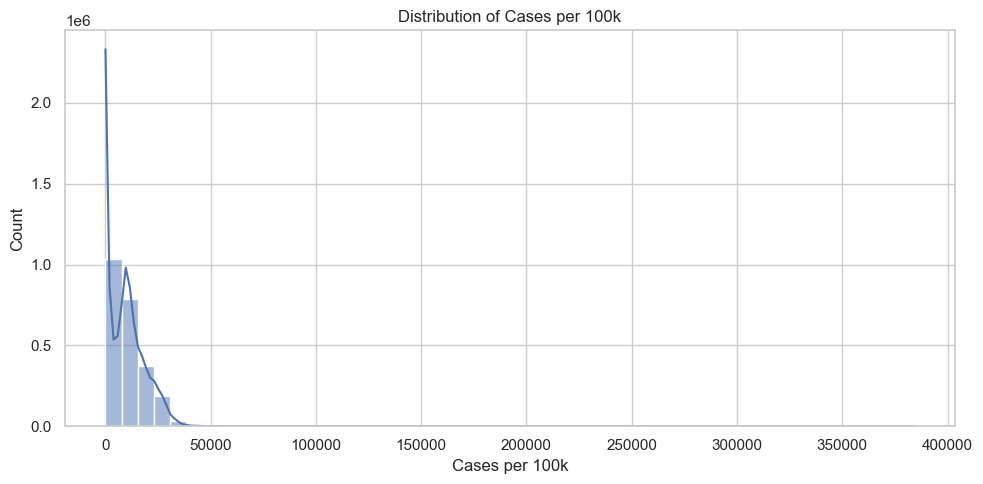

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["u"], bins=50, kde=True)
plt.title("Distribution of Cases per 100k")
plt.xlabel("Cases per 100k")
plt.tight_layout()
plt.show()


**Analysis:**  
The distribution is right-skewed, with a long tail of counties experiencing very high infection rates. Most data points fall below 500 per 100k.

---


### 8.Geographic Snapshots for a Specific Date
We visualize the infection rate across counties on a single median day.

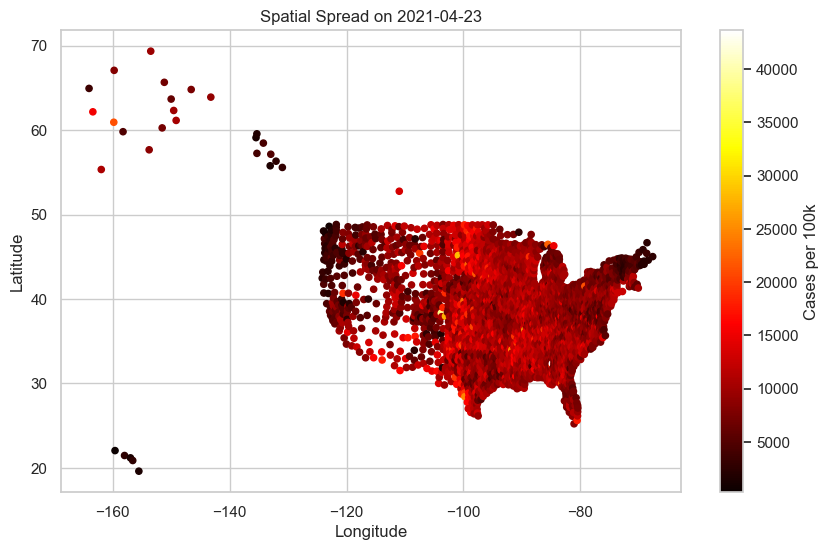

In [11]:
# Pick a snapshot day (e.g., peak period)
snapshot_day = df["date"].median()
df_day = df[df["date"] == snapshot_day]

plt.figure(figsize=(10, 6))
plt.scatter(df_day["lon"], df_day["lat"], c=df_day["u"], cmap="hot", s=20)
plt.colorbar(label="Cases per 100k")
plt.title(f"Spatial Spread on {snapshot_day.date()}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


**Analysis:**  
Geographic variation in infection intensity is clearly visible. Certain hotspots are evident, possibly urban centers. This spatial map offers a useful way to model regional dynamics later.

---


### 9.Rolling Average
This smooths daily noise and captures trends.

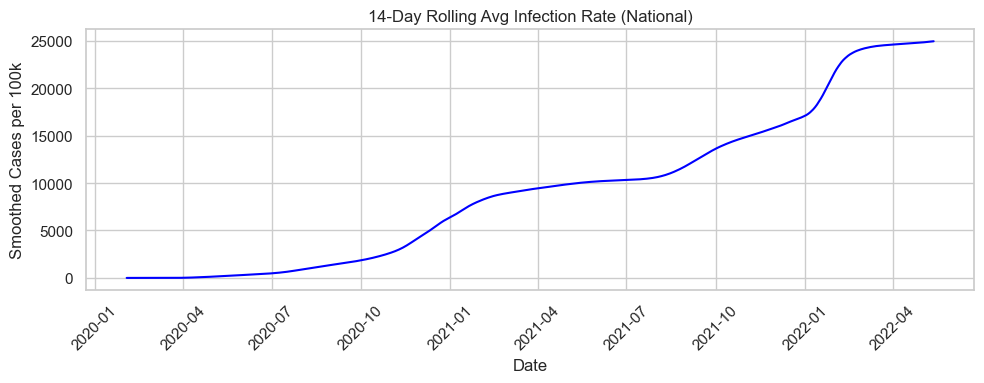

In [12]:
df_rolling = df.groupby("date")["u"].mean().rolling(window=14).mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_rolling, x="date", y="u", color="blue")
plt.title("14-Day Rolling Avg Infection Rate (National)")
plt.xlabel("Date")
plt.ylabel("Smoothed Cases per 100k")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis:**  
This plot smooths out day-to-day volatility, showing the three major pandemic phases with clear transitions and drop-offs. This can help guide training windows for time-series models.

---


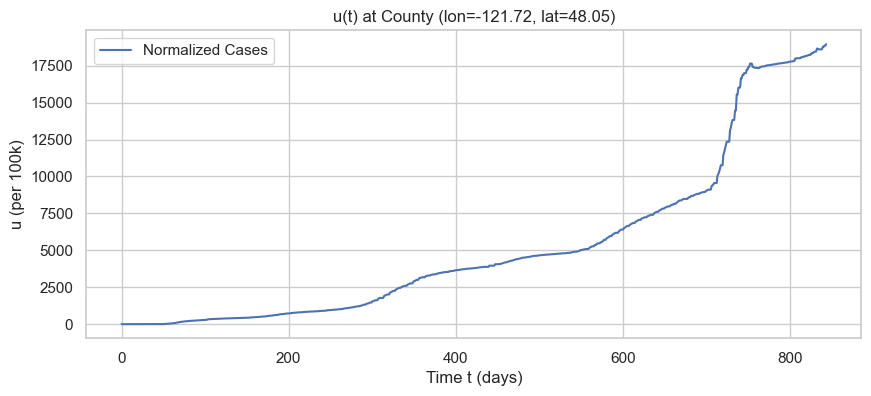

In [13]:
# Pick a random location
sample = df.groupby(["lon", "lat"]).size().sort_values(ascending=False).index[0]
df_sample = df[(df["lon"] == sample[0]) & (df["lat"] == sample[1])]

plt.figure(figsize=(10, 4))
plt.plot(df_sample["t"], df_sample["u"], label="Normalized Cases")
plt.title(f"u(t) at County (lon={sample[0]:.2f}, lat={sample[1]:.2f})")
plt.xlabel("Time t (days)"); plt.ylabel("u (per 100k)")
plt.grid(True)
plt.legend()
plt.show()


### Conclusions

- Temporal trends align with known pandemic waves.
- Spatial variation suggests that geographic modeling is necessary.
- Rolling averages are essential to suppress noise in training data.

This analysis supports using Physics-Informed Neural Networks (PINNs) with both spatial and temporal inputs for modeling spread dynamics.

---



In [15]:
def load_nyt_raw_data():
    url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
    df = pd.read_csv(url, parse_dates=["date"])
    df = df[df["fips"].notna()]
    df["fips"] = df["fips"].astype(float).astype(int).astype(str).str.zfill(5)
    df.to_csv(config["raw_data_path"], index=False)
    print("Saved normalized dataset to: ",config["raw_data_path"])

    return df
df=load_nyt_raw_data()

Saved normalized dataset to:  ./dataset/raw_covid_county_cases.csv


In [17]:
# Convert date
df["date"] = pd.to_datetime(df["date"])

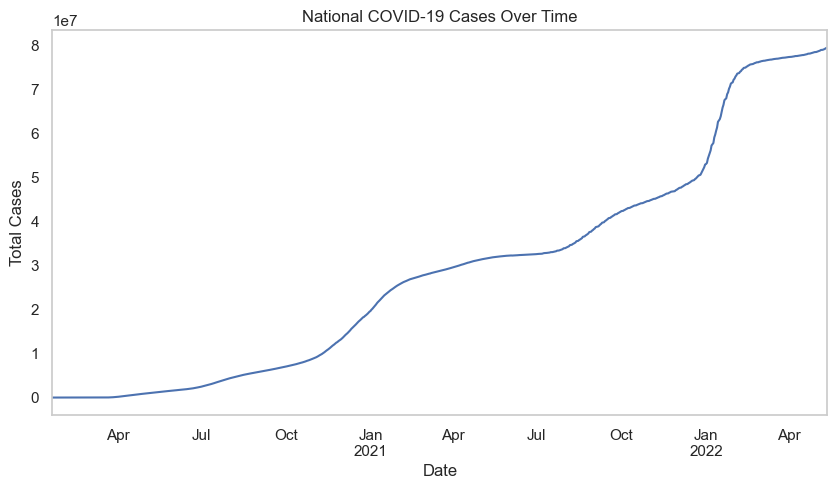

In [18]:
# Total cases over time (U.S.)
national_cases = df.groupby("date")["cases"].sum()
plt.figure(figsize=(10, 5))
national_cases.plot(title="National COVID-19 Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.grid()
plt.show()

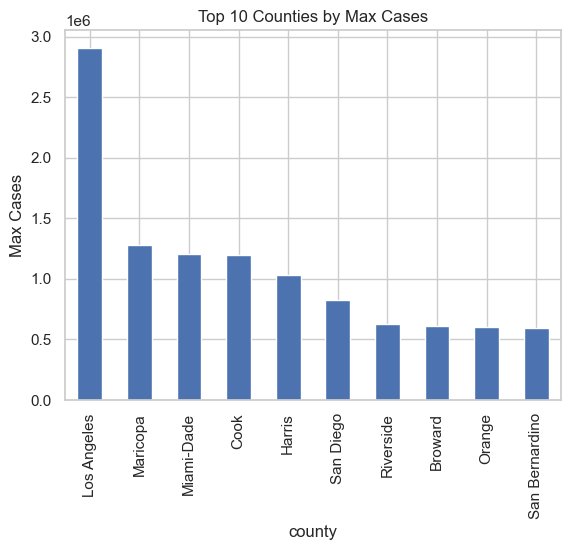

In [19]:
# Top 10 counties by total cases
top_counties = df.groupby("county")["cases"].max().nlargest(10)
top_counties.plot(kind="bar", title="Top 10 Counties by Max Cases")
plt.ylabel("Max Cases")
plt.show()

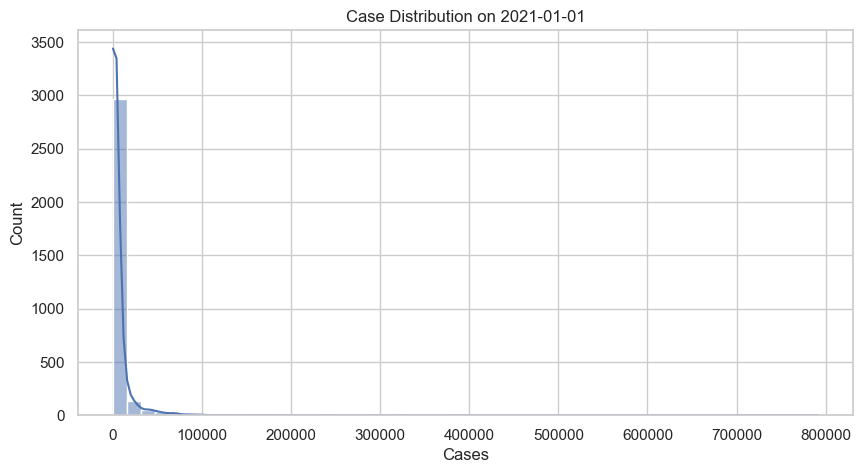

In [20]:
# Cases heatmap: example on a single date
single_day = df[df["date"] == "2021-01-01"]
pivot = single_day.pivot_table(index="fips", values="cases")
plt.figure(figsize=(10, 5))
sns.histplot(single_day["cases"], bins=50, kde=True)
plt.title("Case Distribution on 2021-01-01")
plt.xlabel("Cases")
plt.show()


[INFO] PINN Dataset Summary


,lon,lat,t,u
count,2.409352e+06,2.409352e+06,2.409352e+06,2.409352e+06
mean,-9.214093e+01,3.838049e+01,4.573247e+02,1.011351e+04
std,1.261735e+01,5.230411e+00,2.235216e+02,8.760030e+03
min,-1.640401e+02,1.960199e+01,0.000000e+00,1.028686e-02
25%,-9.808979e+01,3.464985e+01,2.650000e+02,2.138229e+03
50%,-9.024324e+01,3.832408e+01,4.580000e+02,9.257088e+03
75%,-8.343685e+01,4.174292e+01,6.510000e+02,1.522107e+04
max,-6.762834e+01,6.935328e+01,8.430000e+02,3.843137e+05


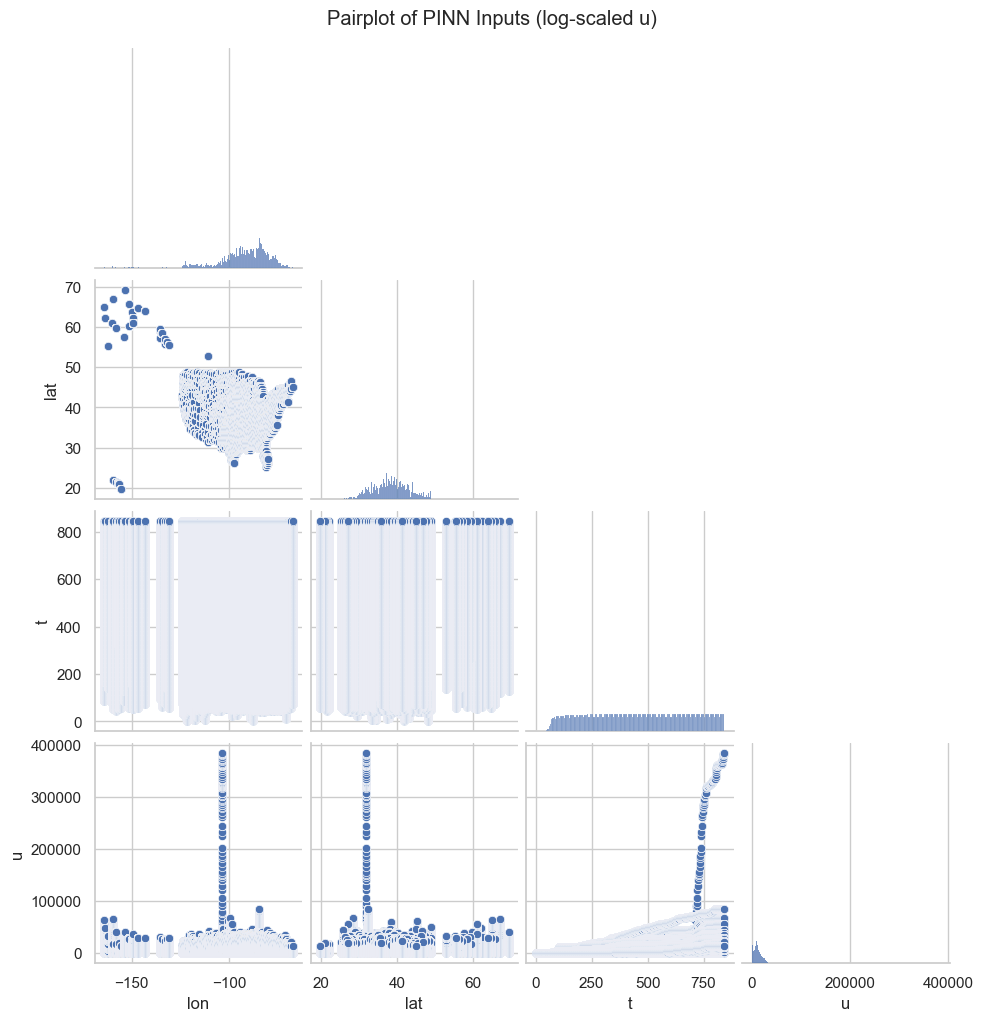

In [21]:
data_path = config["data_path"]
pinn_df = pd.read_csv(data_path)

print("[INFO] PINN Dataset Summary")
display(pinn_df.describe())

# Pairplot of inputs
sns.pairplot(pinn_df[["lon", "lat", "t", "u"]], corner=True)
plt.suptitle("Pairplot of PINN Inputs (log-scaled u)", y=1.02)
plt.show()

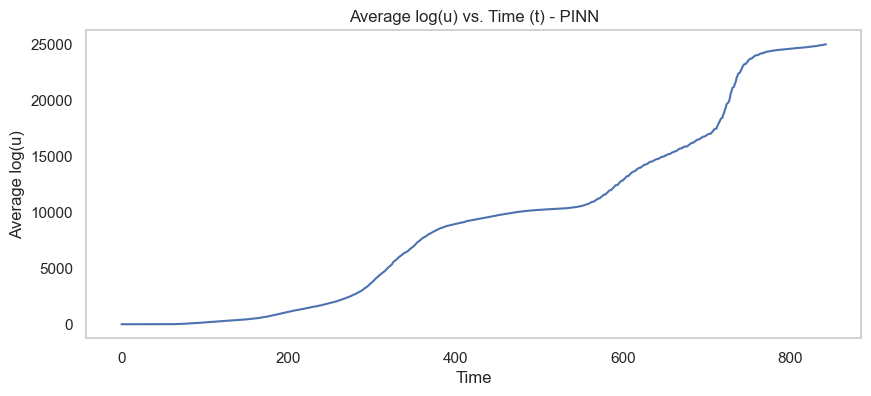

In [23]:
# Time series average
avg_u_time = pinn_df.groupby("t")["u"].mean()
plt.figure(figsize=(10, 4))
avg_u_time.plot()
plt.title("Average log(u) vs. Time (t) - PINN")
plt.xlabel("Time")
plt.ylabel("Average log(u)")
plt.grid()
plt.show()


In [25]:
import torch

In [37]:
# Unpack
graph_dataset, node_positions = torch.load(config["gnn_dataset_path"], weights_only=False)

print(f"[INFO] Loaded {len(graph_dataset)} graph snapshots.")

# Access first graph snapshot
first_graph = graph_dataset[0]

# EDA
num_nodes = first_graph.num_nodes
num_edges = first_graph.edge_index.shape[1]
avg_deg = num_edges / num_nodes

print(f" GNN Graph Summary:")
print(f"  • Nodes: {num_nodes}")
print(f"  • Edges: {num_edges}")
print(f"  • Avg Degree: {avg_deg:.2f}")


[INFO] Loaded 516 graph snapshots.
 GNN Graph Summary:
  • Nodes: 3124
  • Edges: 10410
  • Avg Degree: 3.33


In [39]:
# Feature & target stats
x_all = torch.cat([g.x for g in graph_dataset], dim=0).numpy()
y_all = torch.cat([g.y for g in graph_dataset], dim=0).numpy()

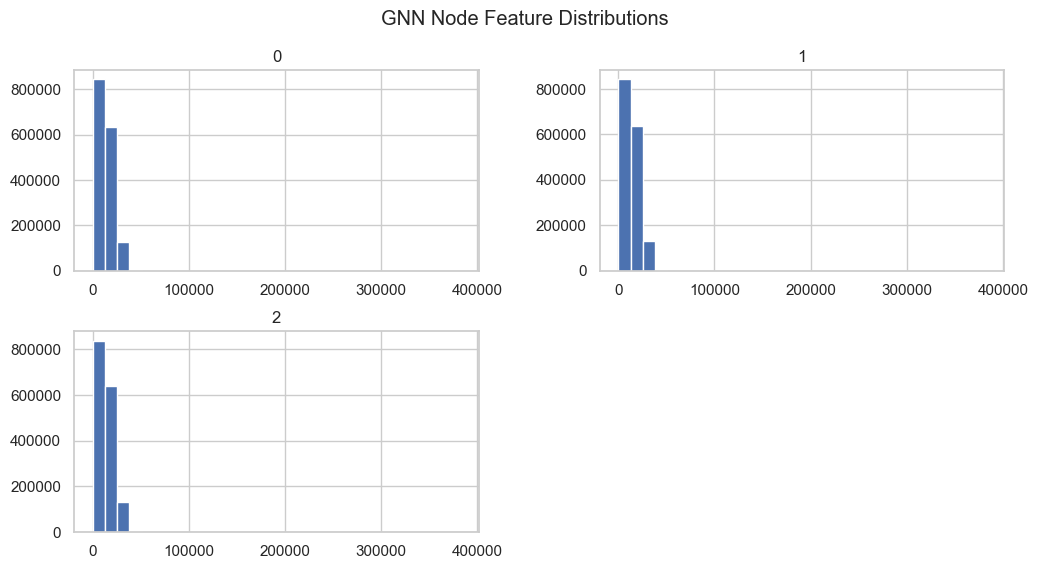

In [40]:
# Node feature histogram
pd.DataFrame(x_all).hist(bins=30, figsize=(12, 6))
plt.suptitle("GNN Node Feature Distributions")
plt.show()


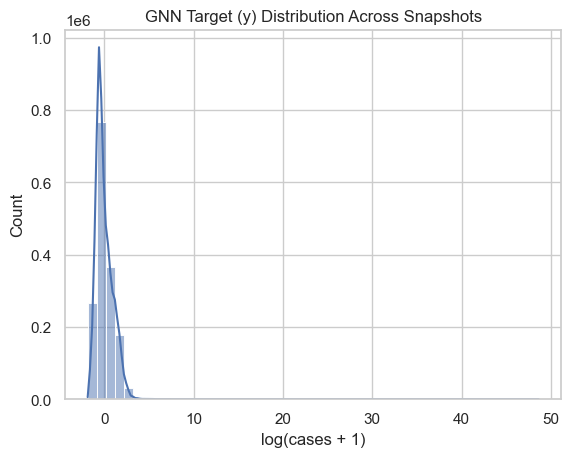

In [42]:
# Target histogram
sns.histplot(y_all, bins=50, kde=True)
plt.title("GNN Target (y) Distribution Across Snapshots")
plt.xlabel("log(cases + 1)")
plt.show()

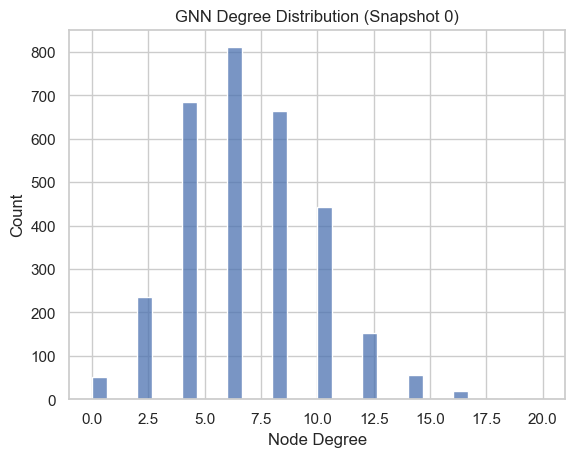

In [43]:
# Degree distribution of a snapshot
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(graph_dataset[0])
degrees = [deg for _, deg in G.degree()]
sns.histplot(degrees, bins=30)
plt.title("GNN Degree Distribution (Snapshot 0)")
plt.xlabel("Node Degree")
plt.ylabel("Count")
plt.show()

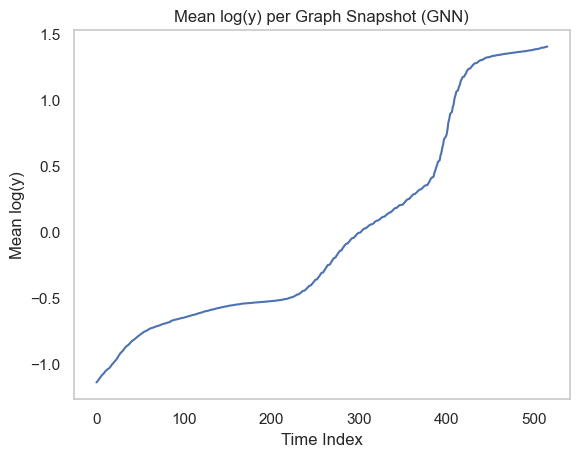

In [44]:
# Time slice trends (target mean over snapshots)
y_per_snapshot = [g.y.mean().item() for g in graph_dataset]
plt.plot(range(len(graph_dataset)), y_per_snapshot)
plt.title("Mean log(y) per Graph Snapshot (GNN)")
plt.xlabel("Time Index")
plt.ylabel("Mean log(y)")
plt.grid()
plt.show()